# Creación de un modelo inicial

In [ ]:
%pip install ucimlrepo
%pip install scikit-learn
%pip install pandas
%pip install matplotlib
%pip install seaborn
%pip install -U imbalanced-learn

## Carga, transformacion y preparacion de datos

### Carga de los datos

Obtenemos el dataset de para el modelo.

In [2]:
from ucimlrepo import fetch_ucirepo

# Descargar dataset con ID 144
statlog_german_credit_data = fetch_ucirepo(id=144)

# Guardar todo el dataset en un DataFrame
df = statlog_german_credit_data.data.original

# Mostrar las 5 primeras filas
df.head(1)

,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,...,Attribute12,Attribute13,Attribute14,Attribute15,Attribute16,Attribute17,Attribute18,Attribute19,Attribute20,class
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1


In [3]:
df = df.rename(columns={
    'Attribute1': 'estado_cuenta',               # Categorical
    'Attribute2': 'duracion_meses',              # Integer
    'Attribute3': 'historial_credito',           # Categorical
    'Attribute4': 'proposito',                    # Categorical
    'Attribute5': 'monto_credito',                # Integer
    'Attribute6': 'cuenta_ahorro_bonos',         # Categorical
    'Attribute7': 'empleo_actual',                # Categorical
    'Attribute8': 'tasa_cuota_ingreso',           # Integer
    'Attribute9': 'estado_civil_sexo',            # Categorical
    'Attribute10': 'otros_deudores_garantes',    # Categorical
    'Attribute11': 'residencia_actual_anios',    # Integer
    'Attribute12': 'propiedad',                    # Categorical
    'Attribute13': 'edad',                         # Integer
    'Attribute14': 'otros_planes_cuotas',         # Categorical
    'Attribute15': 'vivienda',                     # Categorical
    'Attribute16': 'num_creditos_banco',           # Integer
    'Attribute17': 'ocupacion',                    # Categorical
    'Attribute18': 'num_personas_a_cargo',         # Integer
    'Attribute19': 'telefono',                      # Binary
    'Attribute20': 'trabajador_extranjero',         # Binary
    'class': 'buen_mal_credito'                    # Binary (Target)
})

df.head(3)

,estado_cuenta,duracion_meses,historial_credito,proposito,monto_credito,cuenta_ahorro_bonos,empleo_actual,tasa_cuota_ingreso,estado_civil_sexo,otros_deudores_garantes,...,propiedad,edad,otros_planes_cuotas,vivienda,num_creditos_banco,ocupacion,num_personas_a_cargo,telefono,trabajador_extranjero,buen_mal_credito
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1


### Transformacion de datos

Primero vamos a separar el estado el atributo combinado estado_civil_sexo, en 2 nuevas columnas, tenemos estos valores de esa columna:

In [4]:
print(df['estado_civil_sexo'].unique())
print('-'*30)
print(df['estado_civil_sexo'].value_counts())

['A93' 'A92' 'A91' 'A94']
------------------------------
estado_civil_sexo
A93    548
A92    310
A94     92
A91     50
Name: count, dtype: int64


#### Personal status and sex

* A91 : male   : divorced/separated
* A92 : female : divorced/separated/married
* A93 : male   : single
* A94 : male   : married/widowed
* A95 : female : single

In [5]:
map_sexo = {
    'A91': 'male',
    'A92': 'female',
    'A93': 'male',
    'A94': 'male',
    'A95': 'female'
}

map_estado_balanceado = {
    'A91': 'not_single',
    'A92': 'not_single',
    'A93': 'single',
    'A94': 'not_single',
    'A95': 'single'
}

Creamos las nuevas columnas

In [6]:
df['estado_civil'] = df['estado_civil_sexo'].map(map_estado_balanceado)
df['sexo'] = df['estado_civil_sexo'].map(map_sexo)


In [7]:
print(df['estado_civil'].value_counts())
print("-"*30)
print(df['sexo'].value_counts())

estado_civil
single        548
not_single    452
Name: count, dtype: int64
------------------------------
sexo
male      690
female    310
Name: count, dtype: int64


In [8]:
# Eliminamos nuestra columna: 'estado_civil_sexo'
df.drop('estado_civil_sexo', axis=1, inplace=True)

### Preparando datos para enntrenar

En primer lugar, vamos a transformar el dataset utilizando one-hot encoding para que el clasificador pueda procesarlo correctamente. En un principio, consideramos interpretar algunas variables como ordinales para reducir la cantidad de columnas generadas, pero finalmente decidimos no hacerlo.

Aunque muchas categorías tienen un orden lógico y sus descripciones reflejan los límites entre ellas, el tipo de clasificador que elegimos — árboles de decisión — tiende a interpretar estas categorías ordinales como si unas fueran mejores que otras. 

Queríamos evitar introducir un sesgo de etiqueta artificial en el modelo, por lo que preferimos tratarlas como variables categóricas sin orden implícito. De esta manera, no se asume que una categoría es superior o inferior a otra.

Primero aplicamos encoding a los features

In [9]:
import pandas as pd
features = df.drop('buen_mal_credito', axis=1)
features_encoded = pd.get_dummies(features, dtype=int)

Separando features y target

In [10]:
X = features_encoded
Y = df['buen_mal_credito']

## Eleccion del modelo de clasificación

Como modelo de clasificación, elegimos Random Forest porque consideramos que es el método más efectivo para este tipo de datos. Este modelo es capaz de capturar relaciones no lineales complejas, por lo que nos pareció adecuado evitar modelos que puedan tener dificultades para manejar dicha complejidad.

Además, Random Forest maneja de forma eficiente las variables categóricas codificadas mediante one-hot encoding y es menos propenso al sobreajuste gracias a su naturaleza basada en múltiples árboles y técnicas de bagging.

Para utilizar Random Forest, es necesario transformar las columnas categóricas. En nuestro caso, aplicamos one-hot encoding porque las variables no son ordinales, y queremos evitar que el clasificador interprete un orden que no existe entre las categorías.

## Entrenamiento y evaluación del modelo

In [59]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42, stratify=Y)

In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Definir el modelo base
modelo = RandomForestClassifier(random_state=13)
scoring = {
    'accuracy': 'accuracy',
    'f1_weighted': make_scorer(f1_score, average='weighted'),
    'recall_weighted': make_scorer(recall_score, average='weighted')
}

# Definir espacio de hiperparámetros para GridSearch
param_grid = {
    'n_estimators': [15, 20, 50, 100],
    'max_depth': [5, 10, 15, 20, 25],
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=modelo,
    param_grid=param_grid,
    scoring=scoring,
    refit='accuracy',  # El criterio para elegir el mejor modelo y refit
    cv=5,
    n_jobs=-1
)


# Ajustar GridSearchCV a los datos de entrenamiento
grid_search.fit(X_train, y_train)

print("Mejores hiperparámetros:", grid_search.best_params_)

# Obtener el mejor modelo
best_clf = grid_search.best_estimator_

# Entrenar el mejor modelo con todo el conjunto de entrenamiento
best_clf.fit(X_train, y_train)

# Predecir en conjunto de prueba
y_pred = best_clf.predict(X_test)

# Calcular métricas clásicas para multiclase
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')


Mejores hiperparámetros: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 0.7720
Precision: 0.7628
Recall: 0.7720
F1-score: 0.7497


## Matriz de confusión

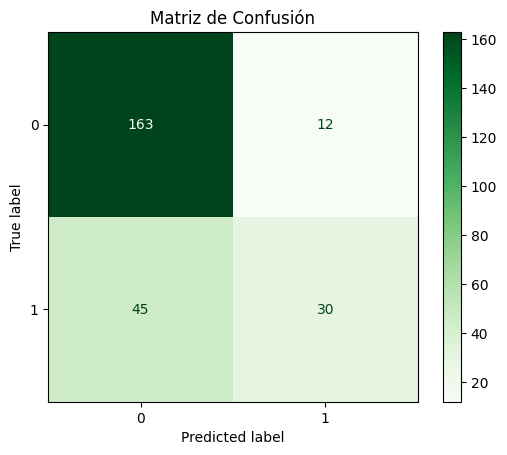

In [64]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predecir en conjunto de prueba
y_pred = best_clf.predict(X_test)

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Mostrar la matriz de confusión con etiquetas y colores
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Greens)
plt.title('Matriz de Confusión')
plt.show()


## Interpretacion de resultados

## Justificacion